<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from catboost import CatBoostClassifier
import nltk
nltk.download('averaged_perceptron_tagger')
import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer 
import time
sns.set(style='darkgrid', font_scale=1.4)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('datasets/toxic_comments.csv', index_col=0) 

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.duplicated().sum()

0

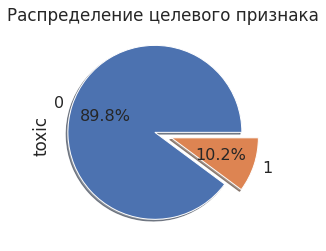

In [5]:
data['toxic'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True,
                                             textprops={'fontsize':16}).set_title("Распределение целевого признака");

Имеем большой дисбаланс классов

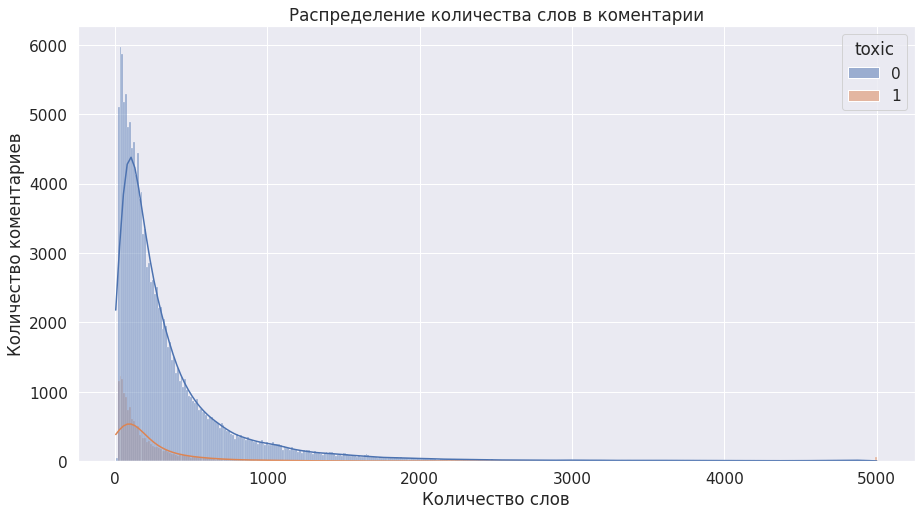

In [6]:
plt.figure(figsize=(15,8))
data['length'] = data['text'].apply(len)
ax = sns.histplot(data=data, x='length', hue='toxic', kde=True)
plt.title('Распределение количества слов в коментарии')
plt.ylabel('Количество коментариев')
plt.xlabel('Количество слов');

Распределение длин коментариев похоже, отличается только их масштаб

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
def lemmatize(text):
    m = WordNetLemmatizer()
    words = text.split()
    words = [m.lemmatize(word.lower(), get_wordnet_pos(word)) for word in words]
    return ' '.join(words)    

def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split()) 

In [8]:
%%time
data['text_lemm'] = data['text'].apply(lambda x: lemmatize(clear_text(x)))

CPU times: user 16min 34s, sys: 1min 48s, total: 18min 22s
Wall time: 18min 24s


In [9]:
data.head()

,text,toxic,length,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,264,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,112,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,233,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,67,you sir be my hero any chance you remember wha...


In [10]:
X=data['text_lemm']
y=data['toxic']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size= 0.25, random_state= 42)

## Обучение

In [11]:
models = {
    #"LGBM" : LGBMClassifier(random_state=42),
    "Ridge": RidgeClassifier(random_state=42),
    "NB": MultinomialNB(), 
    "SVC": LinearSVC(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42)
}
LR_grid = {'model__C': [1e-5, 1e-3, 1e-1, 1e0, 1e1],
          'model__solver': ['sag'],
           'model__multi_class': ['multinomial'],
          'model__max_iter': [10000],
          'model__penalty': ['l2']}

NB_grid = {'model__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}  

KNN_grid = {'model__n_neighbors': [3, 5, 7, 9],
            'model__p': [1, 2]}

SVC_grid = {'model__C': [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

RF_grid = {'model__n_estimators': [50, 80, 100],
        'model__max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {
        'model__max_depth': [4, 6, 8, 10],
        'model__learning_rate': [0.05, 0.1, 0.15]}
Ridge_grid = {'model__alpha':[200, 230, 250, 270, 290, 300]}
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "Ridge": Ridge_grid,
    "NB": NB_grid
}

In [12]:
def pipeline(X_train, y_train):
    i=0
    model_best_params=models.copy()
    model_best_estimator=models.copy()
    valid_scores=pd.DataFrame({'Model':models.keys(), 'F1': np.zeros(len(models)), 'Training time': np.zeros(len(models))})
    for key, model in models.items():
        pipeline = Pipeline([( "vectorizer" , TfidfVectorizer(stop_words=set(nltk_stopwords.words('english'))
                                                          , max_features=10000, analyzer='word'))
                             ,('model', model)])
        model = RandomizedSearchCV(estimator=pipeline, param_distributions=grid[key], n_jobs=-1,
                                 cv=3, scoring='f1', verbose=2)
        start = time.time()

        model.fit(X_train, y_train)
        valid_scores.iloc[i,1]=model.best_score_

        model_best_params[key]=model.best_params_
        model_best_estimator[key]=model.best_estimator_ 
        
        stop = time.time()
        valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

        print('Model:', key)
        print('Training time (mins):', valid_scores.iloc[i,2])
        print('')
        i+=1
    return valid_scores, model_best_params, model_best_estimator  

In [14]:
valid_scores, best_params, best_estimator = pipeline(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...................................model__alpha=200; total time=   5.0s
[CV] END ...................................model__alpha=200; total time=   5.2s
[CV] END ...................................model__alpha=200; total time=   5.7s
[CV] END ...................................model__alpha=230; total time=   5.1s
[CV] END ...................................model__alpha=230; total time=   5.0s
[CV] END ...................................model__alpha=230; total time=   5.0s
[CV] END ...................................model__alpha=250; total time=   5.0s
[CV] END ...................................model__alpha=250; total time=   5.3s
[CV] END ...................................model__alpha=250; total time=   4.9s
[CV] END ...................................model__alpha=270; total time=   5.0s
[CV] END ...................................model__alpha=270; total time=   5.0s
[CV] END ...................................model

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .....................................model__alpha=1; total time=   5.0s
[CV] END .....................................model__alpha=1; total time=   4.9s
[CV] END .....................................model__alpha=1; total time=   5.0s
[CV] END ...................................model__alpha=0.1; total time=   5.6s
[CV] END ...................................model__alpha=0.1; total time=   5.9s
[CV] END ...................................model__alpha=0.1; total time=   5.8s
[CV] END ..................................model__alpha=0.01; total time=   5.8s
[CV] END ..................................model__alpha=0.01; total time=   5.1s
[CV] END ..................................model__alpha=0.01; total time=   4.9s
[CV] END .................................model__alpha=0.001; total time=   4.9s
[CV] END .................................model__alpha=0.001; total time=   4.8s
[CV] END .................................model__alpha=0.001; total time=   5.2s
[CV] END ...................

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ......................................model__C=0.25; total time=   5.2s
[CV] END ......................................model__C=0.25; total time=   5.4s
[CV] END ......................................model__C=0.25; total time=   5.2s
[CV] END .......................................model__C=0.5; total time=   5.5s
[CV] END .......................................model__C=0.5; total time=   5.6s
[CV] END .......................................model__C=0.5; total time=   5.3s
[CV] END ......................................model__C=0.75; total time=   5.4s
[CV] END ......................................model__C=0.75; total time=   5.5s
[CV] END ......................................model__C=0.75; total time=   5.5s
[CV] END .........................................model__C=1; total time=   5.6s
[CV] END .........................................model__C=1; total time=   6.1s
[CV] END .........................................model__C=1; total time=   5.6s
[CV] END ...................

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__C=1e-05, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=  12.1s
[CV] END model__C=1e-05, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=  11.7s
[CV] END model__C=1e-05, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=  11.8s
[CV] END model__C=0.001, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=   5.9s
[CV] END model__C=0.001, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=   6.0s
[CV] END model__C=0.001, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=   5.9s
[CV] END model__C=0.1, model__max_iter=10000, model__multi_class=multinomial, model__penalty=l2, model__solver=sag; total time=   6.0s
[CV] END model__C=0.1, model__max_iter=1000

In [15]:
valid_scores

,Model,F1,Training time
0,Ridge,0.260912,1.63
1,NB,0.675795,1.64
2,SVC,0.767023,1.78
3,LogisticRegression,0.761669,2.10
4,RandomForest,0.021125,3.75


In [16]:
best_params

{'Ridge': {'model__alpha': 200},
 'NB': {'model__alpha': 0.1},
 'SVC': {'model__C': 1},
 'LogisticRegression': {'model__solver': 'sag',
  'model__penalty': 'l2',
  'model__multi_class': 'multinomial',
  'model__max_iter': 10000,
  'model__C': 10.0},
 'RandomForest': {'model__n_estimators': 50, 'model__max_depth': 12}}

На валидации лучшее качество у модели LinearSVC

## Выводы

In [17]:
stopwords = set(nltk_stopwords.words('english'))
tfidf=TfidfVectorizer(stop_words=stopwords, max_features=10000, analyzer='word',)
X_train=tfidf.fit_transform(X_train)
X_test=tfidf.transform(X_test)

In [18]:
final_model = LinearSVC(C=1, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('F1:', f1_score(y_test, y_pred))

F1: 0.776774552021114


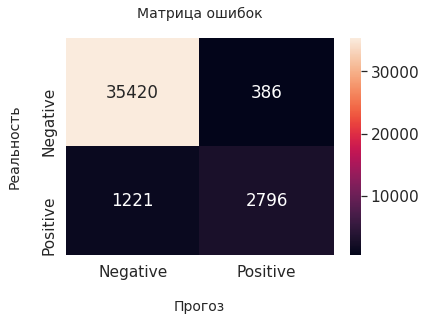

In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )
ax.set_xlabel("Прогоз", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Реальность", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Матрица ошибок", fontsize=14, pad=20)
plt.show()

In [20]:
dummy_cl = DummyClassifier(strategy="constant", constant=1) 
dummy_cl.fit(X_train, y_train) 
dummy_pred = dummy_cl.predict(X_test)
print("F1:", f1_score(dummy_pred, y_test))

F1: 0.18325729927007298


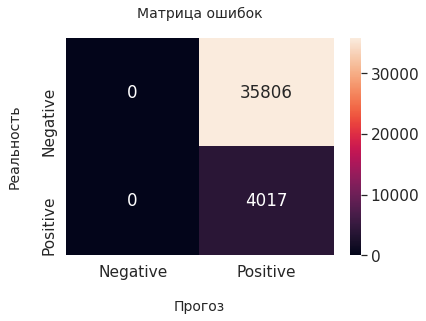

In [21]:
cf_matrix = confusion_matrix(y_test, dummy_pred)
plt.figure(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )
ax.set_xlabel("Прогоз", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Реальность", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Матрица ошибок", fontsize=14, pad=20)
plt.show()

## Вывод

Для построения модели классифицикации комментариев на позитивные и негативные, корпус текстов был очищен от посторонних символов и преведен к лемме. Полученные тексты были векторизированы. В распределении таргета имеется большой дисбаланс классов. На кросс-валидации выбрана модель LinearSVC, показавшая наилучшее качество. Значение метрики F1 сотавило 0.78, что выше заданного бейзлайна. 